# Conditional Flow Matching

This notebook is a self-contained example of conditional flow matching. This notebook is taken from this Github repo https://github.com/atong01/conditional-flow-matching 

In this notebook, we show how to map from a source distribution $q_0$ to a target distribution $q_1$:
* Conditional Flow Matching (CFM)
    * This is equivalent to the basic (non-rectified) formulation of "Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow" [(Liu et al. 2023)](https://openreview.net/forum?id=XVjTT1nw5z)
    * Is similar to "Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) with a non-variance preserving interpolant.
    * Is similar to "Flow Matching" [(Lipman et al. 2023)](https://openreview.net/forum?id=PqvMRDCJT9t) but conditions on both source and target.
* Optimal Transport CFM (OT-CFM), which directly optimizes for dynamic optimal transport

Note that this Flow Matching is different from the Generative Flow Network Flow Matching losses. Here we specifically regress against continuous flows, rather than matching inflows and outflows.

In [2]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

In [3]:
# Implement some helper functions


def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()


class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class GradModel(torch.nn.Module):
    def __init__(self, action):
        super().__init__()
        self.action = action

    def forward(self, x):
        x = x.requires_grad_(True)
        grad = torch.autograd.grad(torch.sum(self.action(x)), x, create_graph=True)[0]
        return grad[:, :-1]


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, args=None):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def plot_trajectories(traj):
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Conditional Flow Matching

First we implement the basic conditional flow matching. As in the paper, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
When $\sigma = 0$ this is equivalent to zero-steps of rectified flow. We find that small $\sigma$ helps to regularize the problem ymmv.

5000: loss 8.896 time 14.94


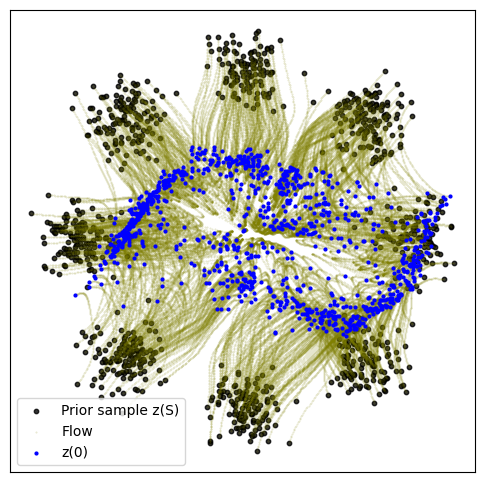

10000: loss 8.825 time 15.87


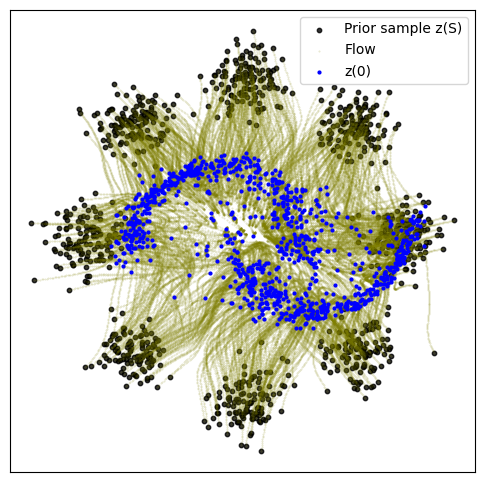

15000: loss 8.178 time 17.13


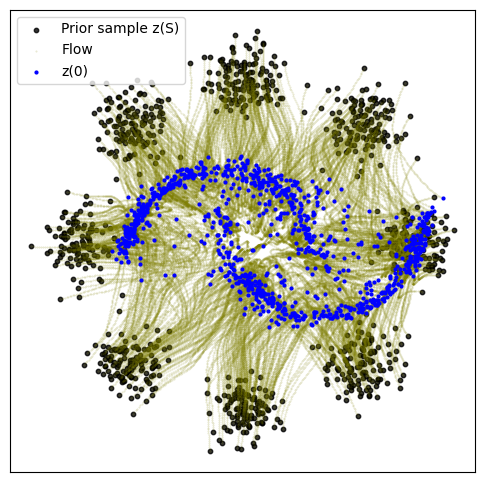

20000: loss 8.456 time 19.18


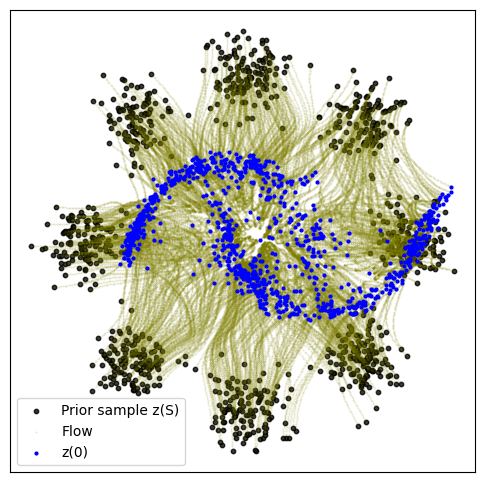

CPU times: user 3min 35s, sys: 26.3 s, total: 4min 1s
Wall time: 1min 7s


In [4]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    mu_t = t * x1 + (1 - t) * x0
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj)
torch.save(model, f"{savedir}/cfm_v1.pt")

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

5000: loss 0.138 time 76.86


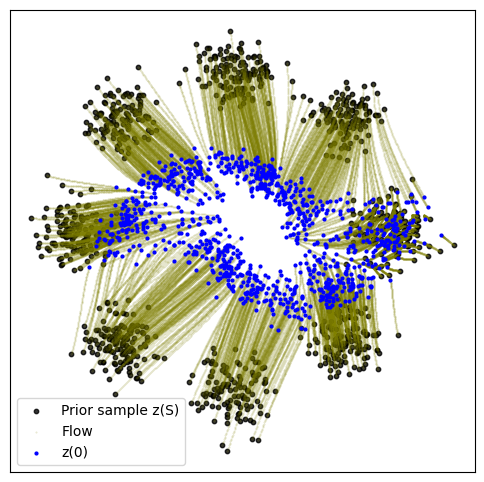

10000: loss 0.103 time 75.88


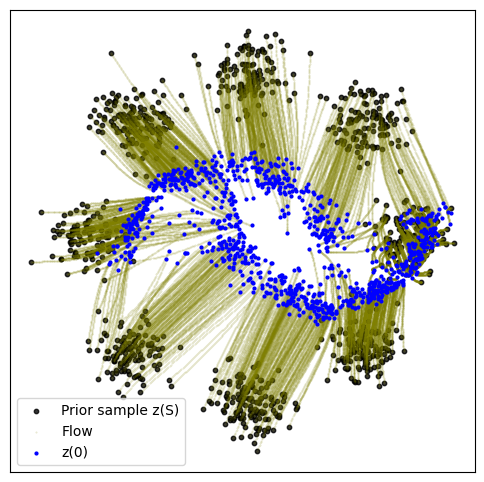

15000: loss 0.217 time 81.70


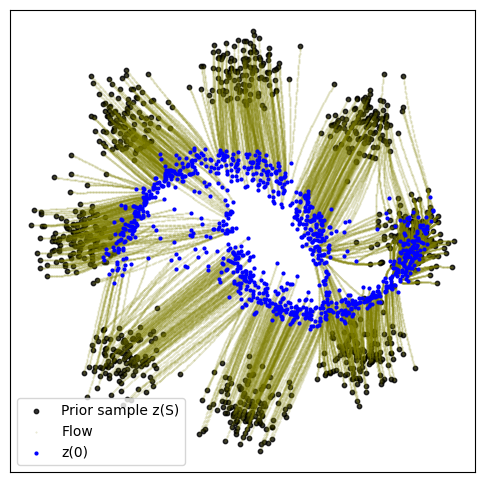

20000: loss 0.114 time 86.51


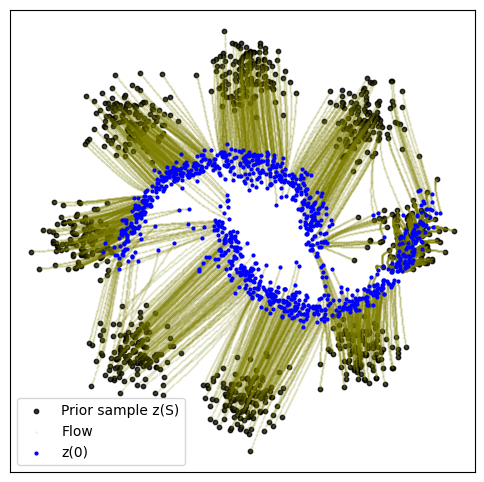

CPU times: user 17min 42s, sys: 1min 52s, total: 19min 34s
Wall time: 5min 21s


In [5]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
a, b = pot.unif(batch_size), pot.unif(batch_size)
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    # Resample x0, x1 according to transport matrix
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    pi = pot.emd(a, b, M.detach().cpu().numpy())
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    x0 = x0[i]
    x1 = x1[j]
    # calculate regression loss
    mu_t = x0 * (1 - t) + x1 * t
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj)
torch.save(model, f"{savedir}/otcfm_v1.pt")